In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import multiseg as ms
import pandas as pd
import numpy as np
%matplotlib inline 
from IPython.display import display, Markdown
import glob
import matplotlib.pyplot as plt

## problem with projection
import os
os.environ["PROJ_LIB"] = r"C:\Users\malvarez\AppData\Local\Continuum\miniconda3\envs\py36\Library\share"

## Configure script

Configures:
* street network type, to be used in osmnx
* geographical data projections
* input data folder 
* output folder

In [2]:
retain_all = False                       #retain all only largest connected component
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops.shp'                    #the input file for all bus stop shaspes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

## Read data 

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
busStopGPD = gpd.read_file('{}/{}'.format(input_folder, busStop))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))


#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(input_folder, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Create boundary from block geometries

Blocks define the urban area that will be used in the analysis. 
An $\alpha$ -shape with $\alpha =0.0025$ is used to create a polygon that define the boundary around multiple unconnected block geometries.

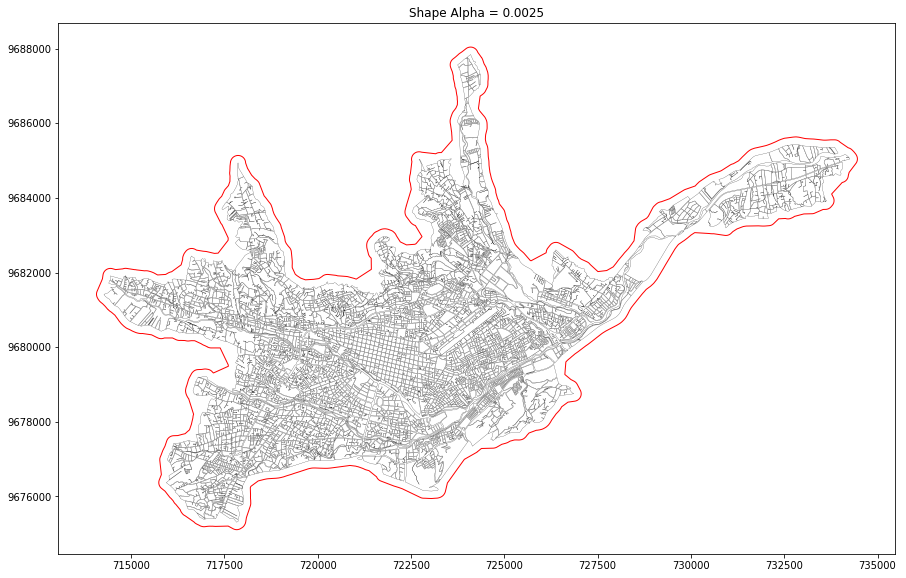

In [5]:
alpha = 0.0025
boundary = ms.boundary_from_areas(blocksGPD, alpha = alpha, buffer_dist=200)
base = blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  figsize = (15,10))
base.set_title("Shape Alpha = {}".format(alpha))
boundary.plot(color = "None", edgecolor='red',linewidth=1, ax = base)
plt.show()

In [6]:
# turn polygon to geopandas data frame with projection
boundaryGPD = gpd.GeoDataFrame(geometry = boundary)
boundaryGPD.crs = crs_utm

## Create street network

Creates a time weighted graph that represents the street network with an average walking speed = 5Km/h.

* data source: OpenStreetMap, using OSMnx

In [7]:
street_network = ms.street_graph_from_boundary(boundaryGPD)

Generating street graph using OSMnx
created street network graph


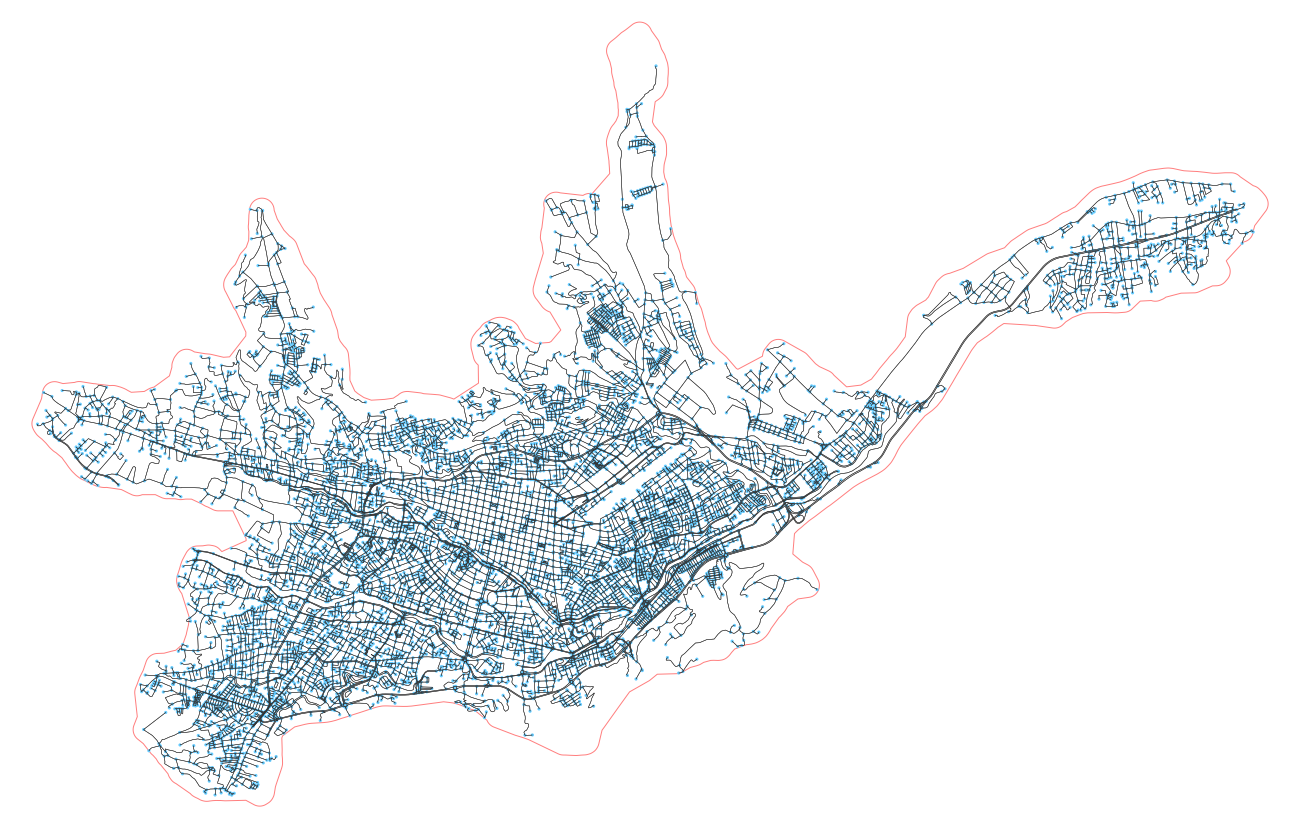

In [8]:
ms.plot_network(street_network, boundary)

## Create bus network

Creates a time weighted graph that represents the bus network with an average speed of = 30Km/h.

* data source: Municipality of Cuenca, Ecuador.

In [9]:
# creates bus network from lines and stops shape file
bus_network = ms.transport_graph_from_lines_stops(busLineGPD, 
                                                  busStopGPD, 
                                                  boundaryGPD, 
                                                  speed = 30,
                                                  name = 'bus_network',
                                                  group_lines_by = "LINEA",
                                                  group_stops_by = "lineNum",
                                                  lines_data = {"LINEA": "line", "RUTA":"route"},
                                                  stops_data = {'C2': 'name', 'N_líneas': 'number_of_lines'})

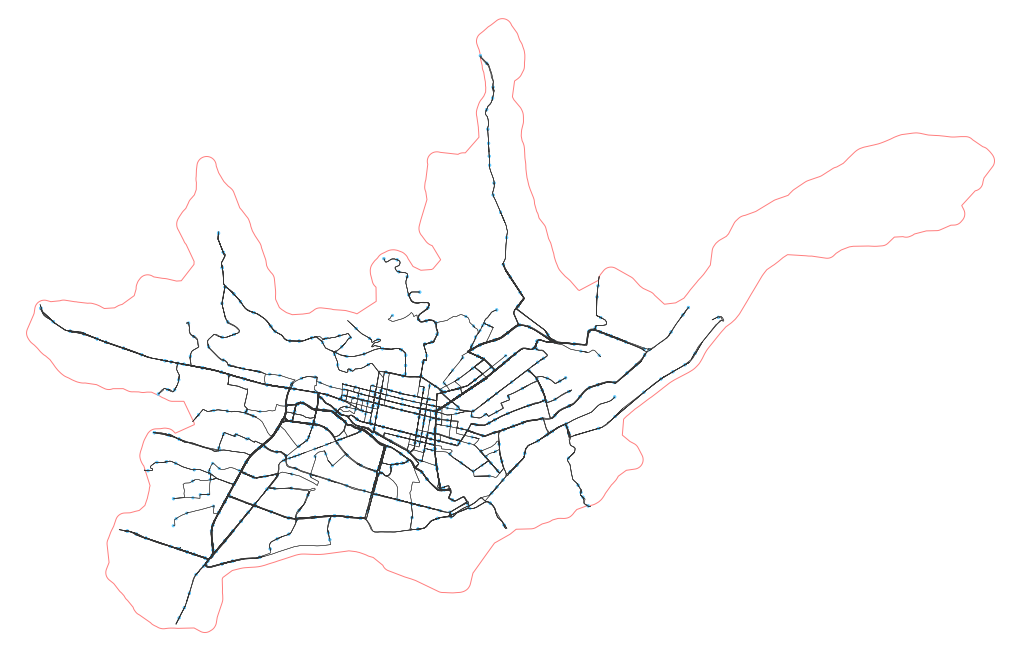

In [10]:
ms.plot_network(bus_network, boundary)

## Create tram network

Creates a time weighted graph that represents the tram network with an average speed of = 30Km/h.

* data source: Municipality of Cuenca, Ecuador.

In [11]:
# creates bus network from lines and stops shape file
tram_network = ms.transport_graph_from_lines_stops(tramLineGPD, 
                                                  tramStopGPD, 
                                                  boundaryGPD, 
                                                  speed = 40,
                                                   name = 'tram_network',
                                                  lines_data = {"Layer": "line"})

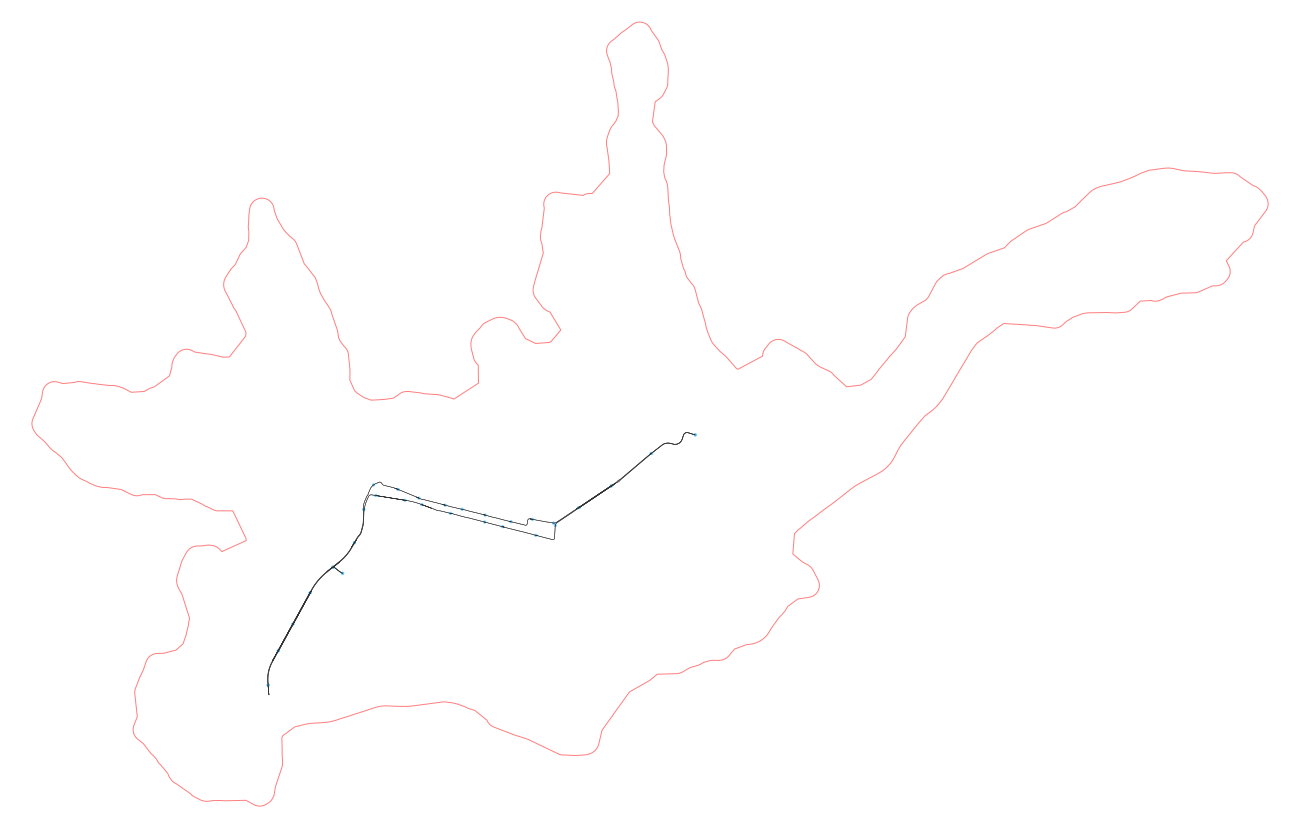

In [12]:
ms.plot_network(tram_network, boundary)

## Assign Socio Economic Data to Nodes

Voronoi tesselation and weighted area overlay interpolation are used to determine population data at each node of the road network.

In [13]:
#join ICV dataframe to block geometry
blocksICV = blocksGPD.merge(icvIndexDf, left_on = 'DPA_MANZAN', right_on = 'id_man')

#only conserve valid geometries with values
blocksICV = blocksICV[blocksICV.is_valid]
blocksICV = blocksICV.dropna()

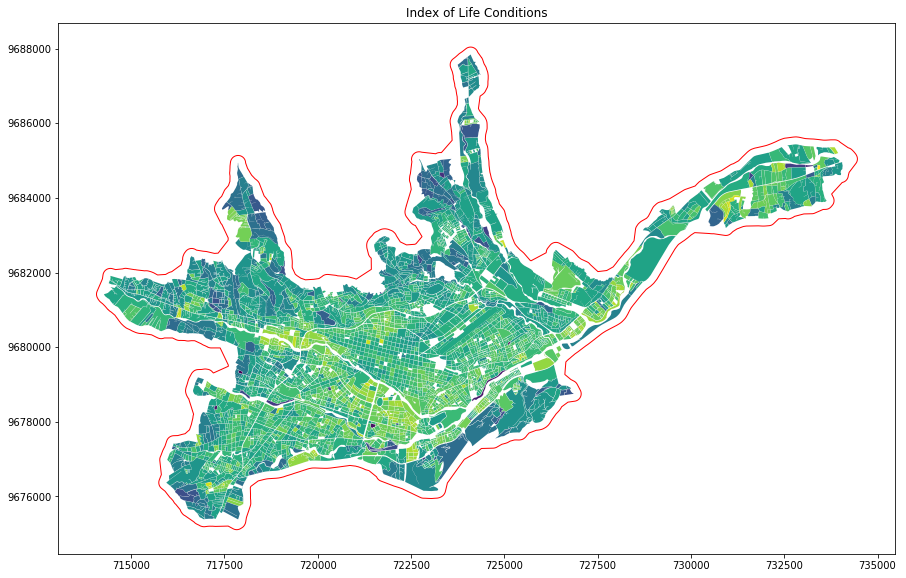

In [14]:
# plot initial data
base = blocksICV.plot(column = "ICV", edgecolor='black', cmap='viridis', linewidth=0.01,  figsize = (15,10))
base.set_title("Index of Life Conditions")
boundary.plot(color = "None", edgecolor='red',linewidth=1, ax = base)
plt.show()

In [15]:
# map data to intersection
street_network = ms.map_values_to_nodes(street_network,
                                        blocksICV, 
                                        boundaryGPD,
                                        population = "nPeople", 
                                        indices = ['ICV'], 
                                        groups = ['Q1', 'Q2', 'Q3', 'Q4'])

## Create Multiplex

A multilayer network $\mathcal{M}$ given by the triple

$$\mathcal{M} = (Y, \vec{G},\mathcal{G})$$

where $Y$ indicates the set of layers

$$Y=\{\alpha|\alpha \in \{1,2,...,M\}\}$$

of the multilayer network and $M$ indicates the total number of layers.

$\vec{G}$ indicates the ordered list of networks characterizing the interactions within each layer $\alpha=1,2,...,M$.

$$\vec{G} = (G_{1}, G{2},...,G_{\alpha},...G_{M})$$

where

$$G_{\alpha}=(V_{\alpha}, E_{\alpha})$$

is the network in layer $\alpha$

Finally, $\mathcal{G}$ is a $M \times M$ list of bipartite networks $\mathcal{G}_{\alpha, \beta}$, given by

$$\mathcal{G}_{\alpha,\beta} = (V_{\alpha}, V_{\beta}, E_{\alpha, \beta})$$

for each $\alpha < \beta$ and $\alpha,\beta \in \{1,2...M\}$. $\mathcal{G}$ indicates the bipartite network with node sets $V_{\alpha}$ and $V_{\beta}$ and the link set $E_{\alpha, \beta}$. The links of the network $\mathcal{G}_{\alpha \beta}$ are called interlinks and connect the nodes of layer $\alpha$ to nodes of a different layer $\beta$.


In [16]:
# create bipartite graphs
B_sb, B_bs = ms.create_bipartite_graph(street_network, bus_network, weight = (15, 0.1))
B_st, B_ts = ms.create_bipartite_graph(street_network, tram_network, weight = (10, 0.1))

In [17]:
# create multiplex
M = ms.MultilayerGraph(layers = [street_network, bus_network, tram_network],
                       bipartite_interlayers = [B_sb, B_bs, B_st, B_ts])

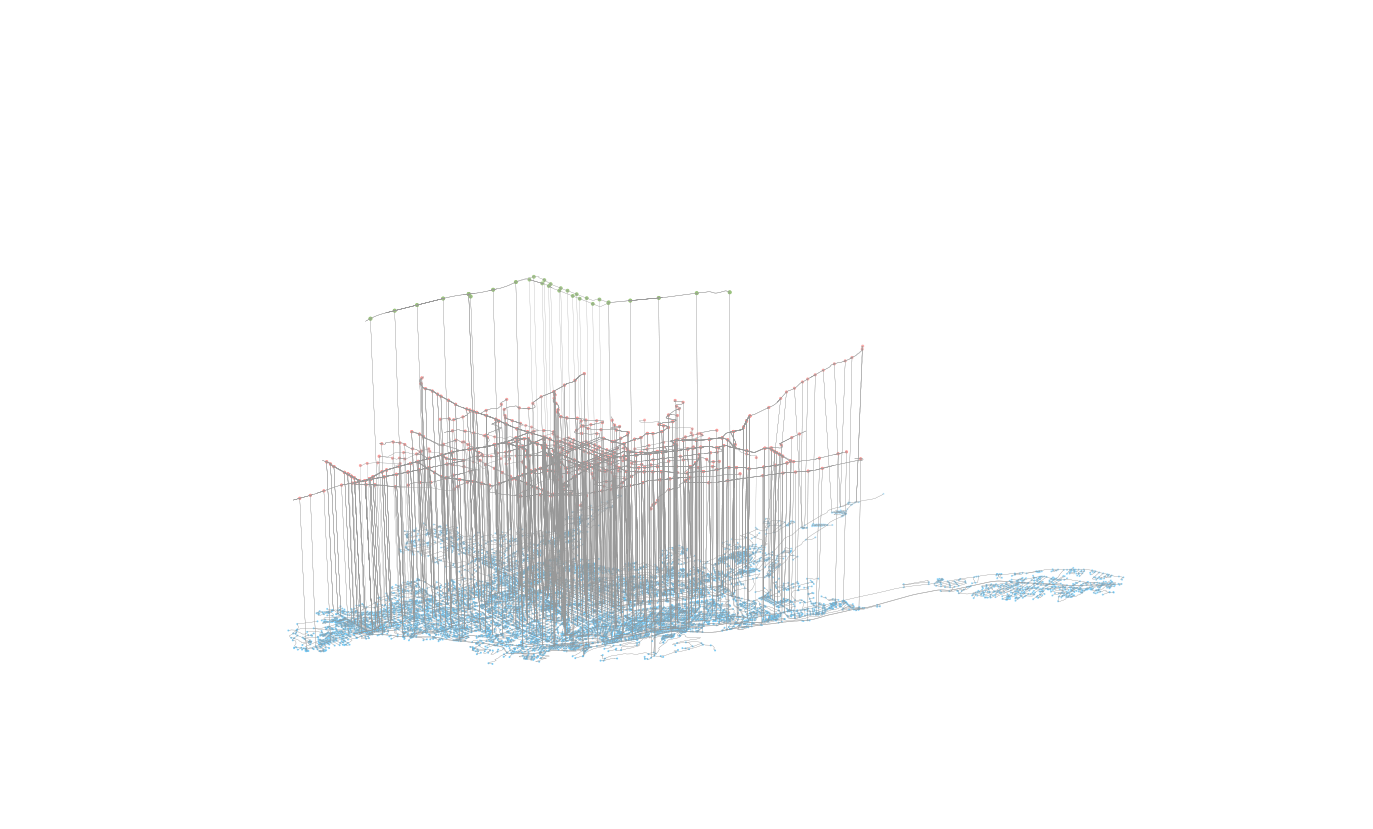

In [18]:
ms.plot_multiplex(M)

In [19]:
display(
    Markdown('**General Information on Multiplex**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Nodes: ' + str(M.number_of_nodes())),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Edges: ' + str(M.number_of_edges())),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Layers: ' + str(M.number_of_layers())),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Interlayer Edges: ' + str(M.number_of_interlayer_edges())),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Intralayer Edges: ' + str(M.number_of_intralayer_edges()))
)

**General Information on Multiplex**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Nodes: 13923

&nbsp;&nbsp;&nbsp;&nbsp;Number of Edges: 52752

&nbsp;&nbsp;&nbsp;&nbsp;Number of Layers: 3

&nbsp;&nbsp;&nbsp;&nbsp;Number of Interlayer Edges: 4302

&nbsp;&nbsp;&nbsp;&nbsp;Number of Intralayer Edges: 48450

## Random walks segregation

The direct extension of such walks to the cas of multiplex networks is to consider the inter-layer connections as additional edges available in vertex $i$. It follow that the probability of moving from vertex $i$ to vertex $j$ within the same yaer $\alpha$ or to switch to the counterpart of vertex $i$ in layer $\beta$ is uniformly distributed. 

### Local random walk

#### Random walk

#### Preferential navigation

### Non-local navigation

#### Lévy random walk

# Test case

#### Manhattan grid

street network of 100 x 100 blocks spanning 10 blocks in x and y direction

In [19]:
blocksGPD, street_network, boundary = ms.generate_manhattan_blocks(num_blocks=(5,5))

In [20]:
# generate population distribution of 2 groups
blocksGPD['group_1'] = 10
blocksGPD['group_2'] = 10
blocksGPD['dummy'] = 0
blocksGPD['nPeople'] = 20

In [21]:
street_network = ms.map_values_to_nodes(street_network,
                                        blocksGPD, 
                                        boundary,
                                        population = "nPeople", 
                                        indices = ['dummy'], 
                                        groups = ['group_1', 'group_2'])

In [22]:
## random walk segregation

In [23]:
ms.random_walk_segregation(street_network, group="group_2")

norm seg for group group_2 = 0.9999999999999998


c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:203: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [24]:
G = street_network
group="group_1"

In [25]:
for i, data in G.nodes(data=True):
    if 'nPeople' not in data.keys():
        G.node[i]['nPeople'] = 0
    if group not in data.keys():
        G.node[i][group] = 0

In [26]:
tesselation = ms.create_node_voronoi(G, boundary)

In [27]:
overlayPoly = ms.area_overlay(blocksGPD, tesselation, "nPeople", ['dummy'], ['group_1', 'group_2'])

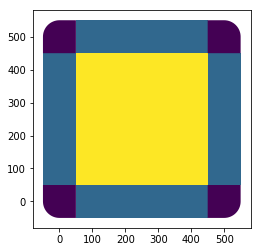

In [28]:
overlayPoly.plot(column="nPeople")

In [29]:
nodes = {node: data for node, data in G.nodes(data=True)}
nodesGPD = gpd.GeoDataFrame(nodes).T
nodesGPD.crs = G.graph['crs']

In [30]:
nodes_attrib = gpd.sjoin(nodesGPD, overlayPoly, how='inner', op='within')

ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined

In [31]:
nodes_attrib.nPeople.sum()

NameError: name 'nodes_attrib' is not defined

In [32]:
nodes_dict = nodes_attrib.to_dict(orient='index')

NameError: name 'nodes_attrib' is not defined

In [33]:
nx.set_node_attributes(G, nodes_dict)

NameError: name 'nx' is not defined

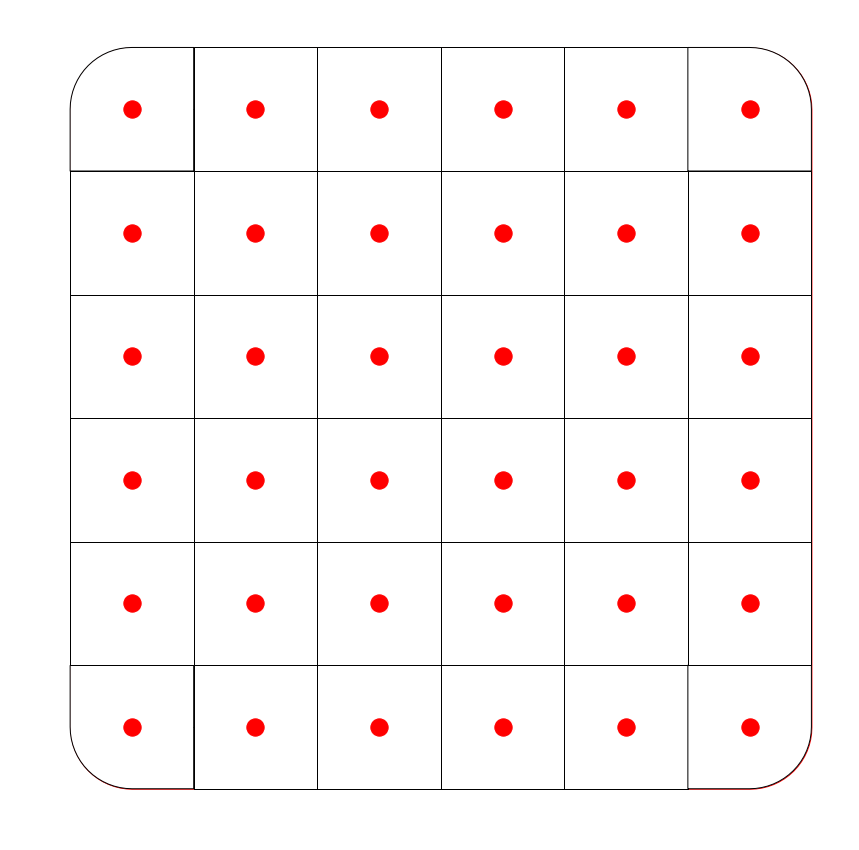

In [182]:
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(ax=ax, color="white", edgecolor="red")
pos = {node: np.array( [float(data['x']), float(data['y'])]) for node, data in street_network.node(data=True)}
nx.draw(street_network, pos = pos, ax = ax)
tesselation.plot(ax=ax, color='white', edgecolor='black')

c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


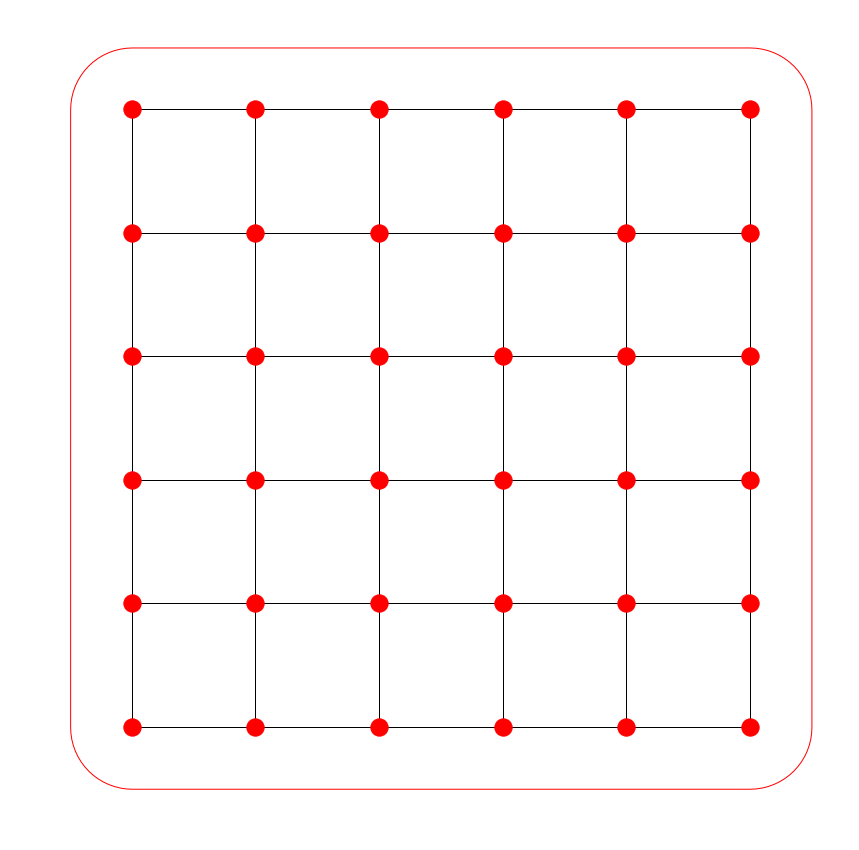

In [121]:
node_x = [float(node['x']) for node in G.node.values()]
node_y = [float(node['y']) for node in G.node.values()]

points = np.column_stack((node_x,node_y))

tessellation = ms.Voronoi(points)

# create polygon from voronoi tessellation
lines = [ms.geometry.LineString(tessellation.vertices[line])
         for line in tessellation.ridge_vertices if -1 not in line]

polygons = list(ms.polygonize(lines))
polygonsGPD = gpd.GeoDataFrame(geometry=polygons)
polygonsGPD.crs = G.graph['crs']

In [134]:
tessellation = ms.Voronoi(points)
lines = [ms.geometry.LineString(tessellation.vertices[line])
         for line in tessellation.ridge_vertices]

In [164]:
regions, vertices = voronoi_finite_polygons_2d(tessellation, radius=200)

In [165]:
polys=[]
for region in regions:
    polygon = vertices[region]
    polys.append(geometry.Polygon(polygon))

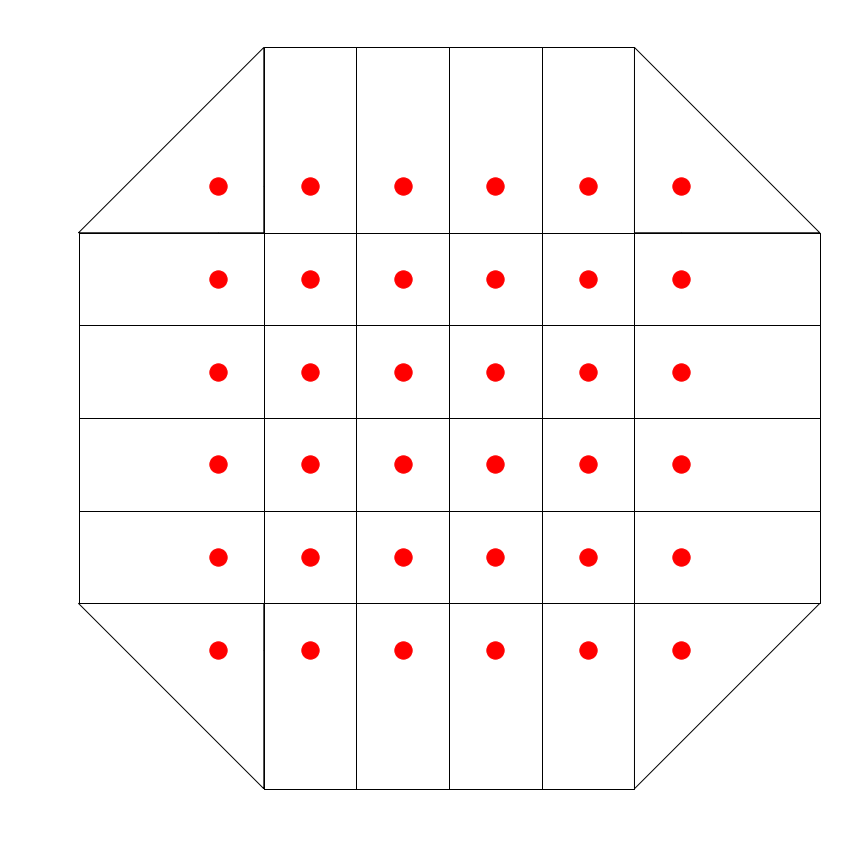

In [167]:
fig, ax = plt.subplots(figsize=(15,15))
# boundary.plot(ax=ax, color="white", edgecolor="red")
pos = {node: np.array( [float(data['x']), float(data['y'])]) for node, data in street_network.node(data=True)}
nx.draw(street_network, pos = pos, ax = ax)
gpd.GeoDataFrame(geometry=polys).plot(ax=ax,color='white', edgecolor='black')

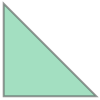

In [150]:
geometry.Polygon(polygon)

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

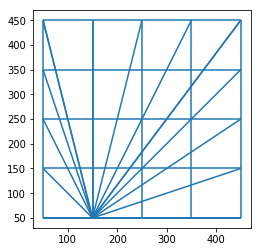

In [135]:
gpd.GeoDataFrame(geometry=lines).plot()

In [136]:
-1 not in line

False

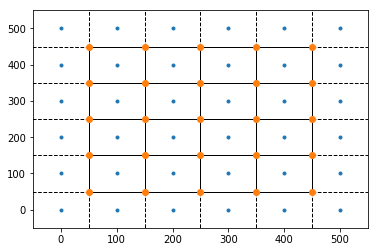

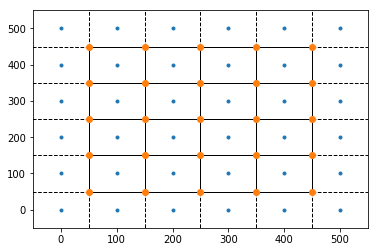

In [122]:
import scipy as sp
sp.spatial.voronoi_plot_2d(tessellation)

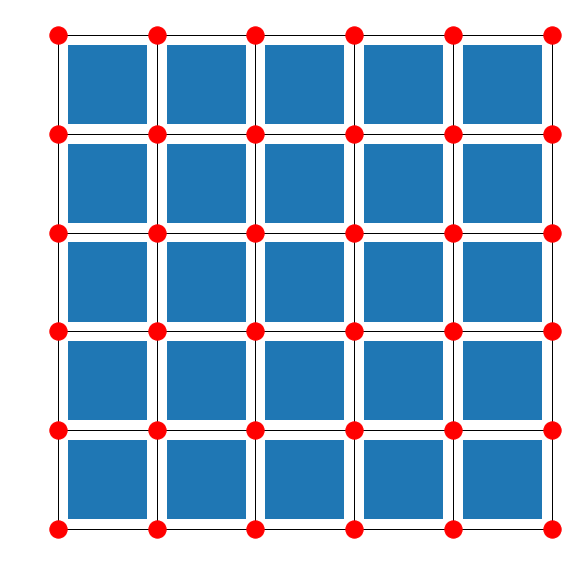

In [77]:
import networkx as nx
fig, ax = plt.subplots(figsize=(10,10))
pos = {node: np.array( [float(data['x']), float(data['y'])]) for node, data in street_network.node(data=True)}
nx.draw(street_network, pos = pos, ax = ax)
blocksGPD.plot(ax=ax)

In [183]:
len(G.edges())

24

In [184]:
len(street_network.edges())

16

In [78]:
pos

{(0, 120): array([  0., 120.]),
 (100, 100): array([100., 100.]),
 (0, 240): array([  0., 240.]),
 (100, 220): array([100., 220.]),
 (120, 120): array([120., 120.]),
 (220, 100): array([220., 100.]),
 (120, 240): array([120., 240.]),
 (220, 220): array([220., 220.])}

In [71]:
nx.spectral_layout(street_network) 

{(0, 120): array([-0.14285714, -0.14285714]),
 (100, 100): array([ 1.        , -0.14285714]),
 (0, 240): array([-0.14285714,  1.        ]),
 (100, 220): array([-0.14285714, -0.14285714]),
 (120, 120): array([-0.14285714, -0.14285714]),
 (220, 100): array([-0.14285714, -0.14285714]),
 (120, 240): array([-0.14285714, -0.14285714]),
 (220, 220): array([-0.14285714, -0.14285714])}

In [75]:
for node, data in street_network.node(data=True):
    print(node)
    print(data)

(0, 120)
{'x': 0, 'y': 120}
(100, 100)
{'x': 100, 'y': 100}
(0, 240)
{'x': 0, 'y': 240}
(100, 220)
{'x': 100, 'y': 220}
(120, 120)
{'x': 120, 'y': 120}
(220, 100)
{'x': 220, 'y': 100}
(120, 240)
{'x': 120, 'y': 240}
(220, 220)
{'x': 220, 'y': 220}


In [35]:
for i in range(10):
    for j in range(10):
        print(j+(i*10))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


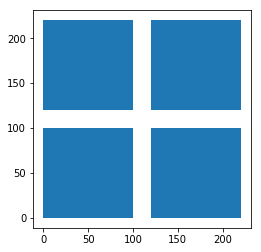

In [29]:
blocksGPD.plot()

In [20]:
import networkx as nx
G =nx.grid_2d_graph([0,10,20,30], [0,10,20,30], periodic=False, create_using=None)

In [23]:
G.nodes(data=True)

NodeDataView({(0, 0): {}, (0, 10): {}, (0, 20): {}, (0, 30): {}, (10, 0): {}, (10, 10): {}, (10, 20): {}, (10, 30): {}, (20, 0): {}, (20, 10): {}, (20, 20): {}, (20, 30): {}, (30, 0): {}, (30, 10): {}, (30, 20): {}, (30, 30): {}})

In [73]:
G = M.copy()
group="Q1"
for i, data in G.nodes(data=True):
    if 'nPeople' not in data.keys():
        G.node[i]['nPeople'] = 0
    if group not in data.keys():
        G.node[i][group] = 0

In [74]:
import networkx as nx
n_i = np.array(list(nx.get_node_attributes(G, 'nPeople').values()))

In [75]:
n_i

array([ 0.        , 56.76856863,  0.        , ...,  0.        ,
        0.        ,  0.        ])

In [76]:
n = n_i.sum()
print(n)

329173.7666070331


In [77]:
c_gi = np.array(list(nx.get_node_attributes(G, "Q1").values()))
print(c_gi)

[0.         0.11682395 0.         ... 0.         0.         0.        ]


In [78]:
n_gi = c_gi *n_i
n_g = n_gi.sum()
d_gi = n_gi /n_g

In [79]:
print(n_gi)
print(n_g)
print(d_gi)

[0.         6.63192817 0.         ... 0.         0.         0.        ]
78288.55991280434
[0.00000000e+00 8.47113318e-05 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [80]:
c_gi.shape = (len(c_gi),1)
d_gi.shape = (len(d_gi),1)
print(c_gi)

[[0.        ]
 [0.11682395]
 [0.        ]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


In [81]:
Adj = nx.adjacency_matrix(G, weight = None)

In [82]:
Adj.todense()

matrix([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [83]:
import scipy as sp
Degree = sp.sparse.spdiags(1./Adj.sum(1).T, 0, *Adj.shape)

In [84]:
1./Degree.todense()

c:\users\malvarez\appdata\local\continuum\miniconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


matrix([[ 3., inf, inf, ..., inf, inf, inf],
        [inf,  4., inf, ..., inf, inf, inf],
        [inf, inf,  3., ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ...,  3., inf, inf],
        [inf, inf, inf, ..., inf,  4., inf],
        [inf, inf, inf, ..., inf, inf,  3.]])

In [85]:
Adj.sum(1).T

matrix([[3, 4, 3, ..., 3, 4, 3]])

In [86]:
I = sp.identity(len(G))    
P = Degree * Adj

In [87]:
P.todense()

matrix([[0.        , 0.        , 0.33333333, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.33333333, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [88]:
alpha = 0.85
Q = (1-alpha) * (I - alpha * P).I * P

In [89]:
Q

matrix([[1.06391953e-01, 2.15023822e-12, 1.32615009e-01, ...,
         5.97257351e-10, 9.18331716e-15, 5.82604503e-13],
        [1.61267866e-12, 5.92486150e-02, 1.77312215e-12, ...,
         9.71466530e-08, 1.20241965e-06, 4.71580882e-05],
        [1.32615009e-01, 2.36416287e-12, 1.00491988e-01, ...,
         6.56021683e-10, 1.00951407e-14, 6.40458853e-13],
        ...,
        [5.97257351e-10, 1.29528871e-07, 6.56021683e-10, ...,
         6.77470535e-02, 4.22827921e-07, 3.08290575e-05],
        [6.88748787e-15, 1.20241965e-06, 7.57135552e-15, ...,
         3.17120940e-07, 6.20221472e-02, 2.19075109e-03],
        [5.82604503e-13, 6.28774509e-05, 6.40458853e-13, ...,
         3.08290575e-05, 2.92100145e-03, 5.91731885e-02]])

In [90]:
isolation_gi = np.multiply(d_gi,(Q*c_gi))

norm_isolation_gi = (n_g/n)**-1 * isolation_gi * len(isolation_gi)
print('norm seg for group {} = {}'.format(group,norm_isolation_gi.mean()))
sigma_bar = list(np.array(norm_isolation_gi.flatten())[0])
res = dict(zip(list(G.nodes()), sigma_bar))

norm seg for group Q1 = 1.2065662111664963


In [94]:
norm_isolation_gi

matrix([[0.        ],
        [0.54072364],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]])

In [24]:
# import networkx as nx
# import scipy as sp

# G=M
# alpha=0.85
# # create 0 values for nodes without values
# groups = ['Q1','Q2', 'Q3', 'Q4']
# for group in groups:
#     for i, data in G.nodes(data=True):
#         if 'nPeople' not in data.keys():
#             G.node[i]['nPeople'] = 0
#         if group not in data.keys():
#             G.node[i][group] = 0


#     ##get the values we need
#     n_i = np.array(list(nx.get_node_attributes(G, 'nPeople').values()))
#     n = n_i.sum()

#     c_gi = np.array(list(nx.get_node_attributes(G,group).values()))
#     n_gi = c_gi * n_i
#     n_g = n_gi.sum()
#     d_gi = n_gi / n_g

#     c_gi.shape = (len(c_gi),1)
#     d_gi.shape = (len(d_gi),1)

#     W = nx.adjacency_matrix(G, weight='betweenness')
#     Degree = sp.sparse.spdiags(1./W.sum(1).T, 0, *W.shape)
#     I = sp.identity(len(G))
#     P = Degree * W
#     Q = (1-alpha) * (I - alpha * P).I * P

#     isolation_gi = np.multiply(d_gi,(Q*c_gi))

#     norm_isolation_gi = (n_g/n)**-1 * isolation_gi * len(isolation_gi)
#     print('norm seg for group {} = {}'.format(group,norm_isolation_gi.mean()))
#     sigma_bar = list(np.array(norm_isolation_gi.flatten())[0])
#     res = dict(zip(list(G.nodes()), sigma_bar))

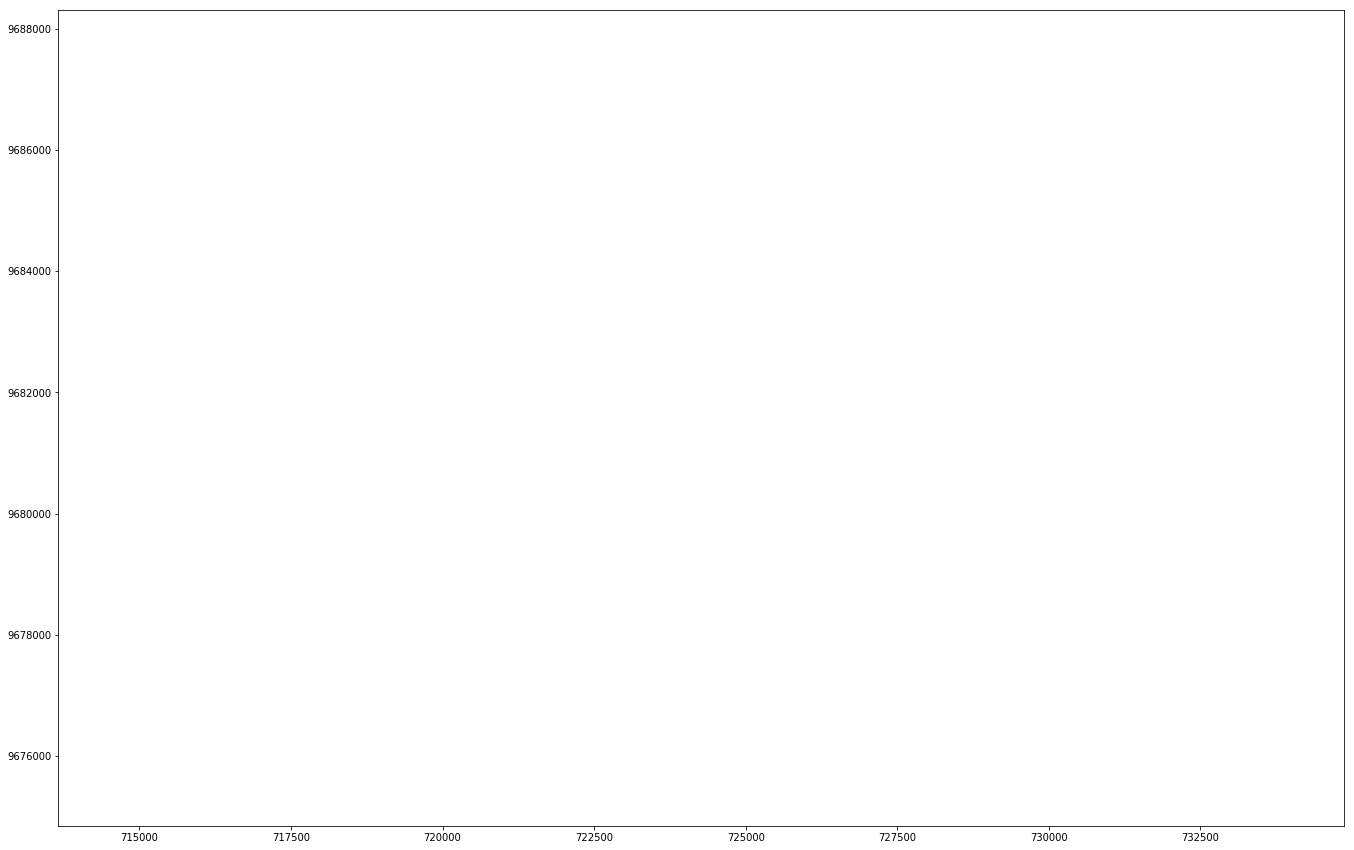

In [44]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import matplotlib.animation
from matplotlib.collections import LineCollection
from descartes import PolygonPatch

edge_color = '#333333'
node_color='#66ccff'
node_edgecolor='none'
edge_linewidth = 0.5
node_alpha=1
edge_alpha=1
node_size=15
node_zorder=1

# get bounds of area or fig size
west, south, east, north = boundaryGPD.geometry[0].bounds
margin = 0.02
margin_ns = (north - south) * margin
margin_ew = (east - west) * margin
fig_height = 15
bbox_aspect_ratio = (north - south)/(east - west) 
fig_width = fig_height / bbox_aspect_ratio
bgcolor = "w"

# Build plot
fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))
xaxis = ax.get_xaxis()
yaxis = ax.get_yaxis()

xaxis.get_major_formatter().set_useOffset(False)
yaxis.get_major_formatter().set_useOffset(False)
ax.set_aspect('equal')

i = 1068
t=1
def init_draw(t=1):
    G_i = nx.ego_graph(Streets_Network, i, radius=t, center=True, distance="weight")

def update(t):
#     ax.clear()
    t = t*0.75
    G_i = nx.ego_graph(Streets_Network, i, radius=t, center=True, distance="weight")
    
    node_Xs = [float(x) for _, x in G_i.nodes(data='x')]
    node_Ys = [float(y) for _, y in G_i.nodes(data='y')]
    
    lines = []
    for u, v, data in G_i.edges(keys=False, data=True):
        if 'geometry' in data:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G_i.nodes[u]['x']
            y1 = G_i.nodes[u]['y']
            x2 = G_i.nodes[v]['x']
            y2 = G_i.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    lc = LineCollection(lines, colors=edge_color, linewidths=edge_linewidth, alpha=edge_alpha, zorder=2)
    ax.add_collection(lc)
    # scatter plot the nodes
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    
    urban_outline = PolygonPatch(boundary.geometry[0],
                             fc="w",
                             ec="r",
                             linewidth=1,
                             alpha=0.5,
                             zorder=-1
                             )
    
    
    
    ax.add_patch(urban_outline)
    ax.set_title("Time: {}".format(str(t)))
    
    
ani = matplotlib.animation.FuncAnimation(fig, update, frames=110, interval=100, init_func=init_draw, repeat=True)
plt.show()

In [27]:
temp = gpd.GeoDataFrame(dict(M.nodes(data=True))).T

In [31]:
temp.layer.unique()

array(['street network_UTM', 'bus_network', 'tram_network'], dtype=object)

In [45]:
ani.save("street_network.mp4")

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


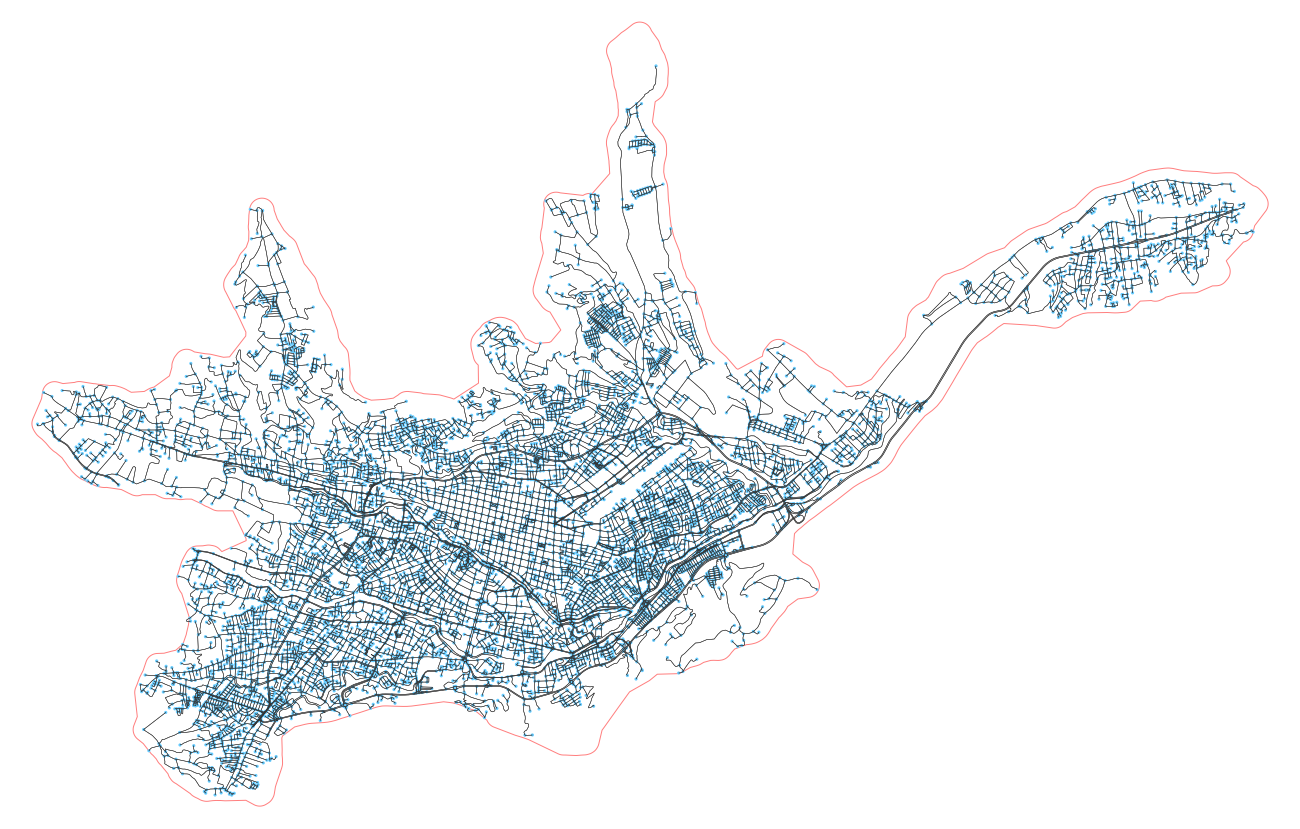

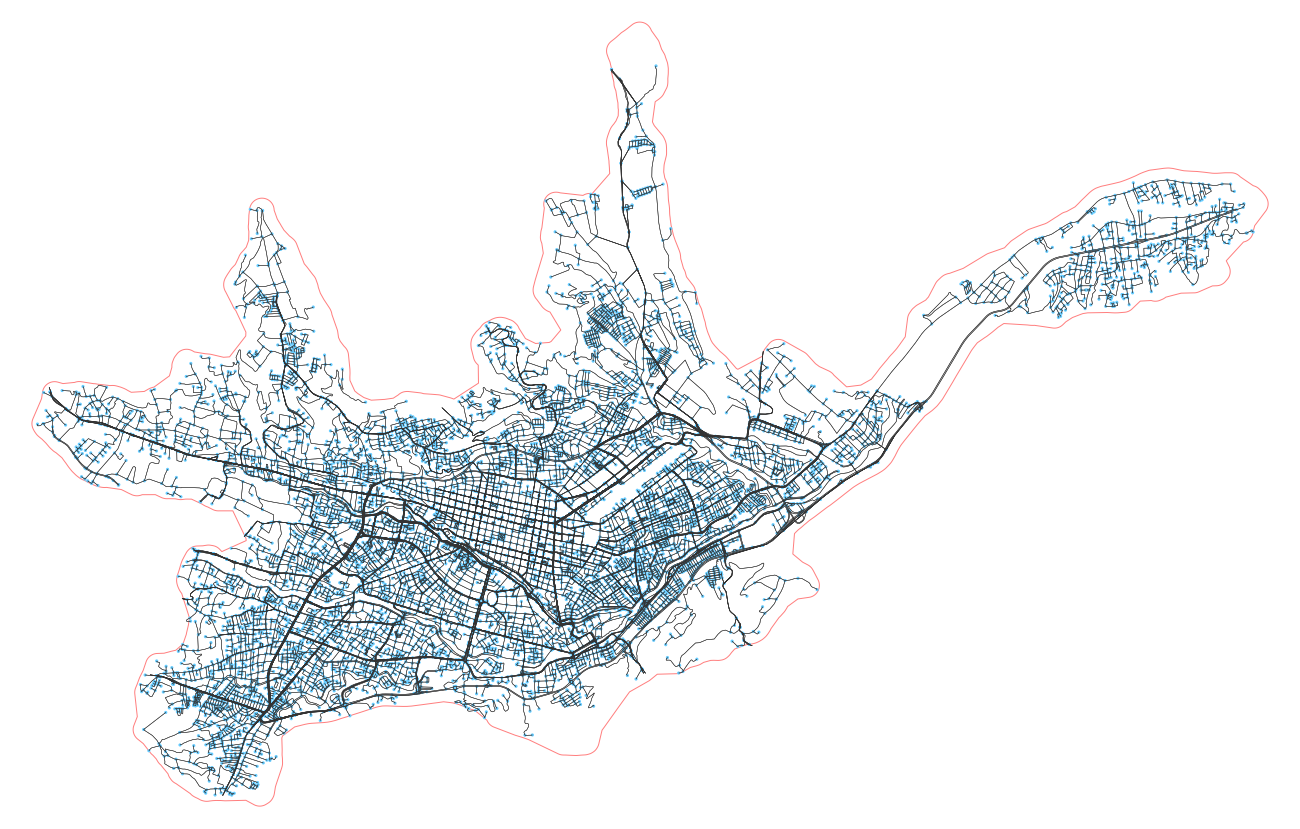